# Enron POI Detector
## 1. Data Exploration
Enron was a big scandal in Wallstreet that embodied greed, pride and fraud in Corporate America. Originally an energy company in Natural Gas, it became big when it started to trade energy in the stock exchange. They used this thing called "Mark-to-Market" pitch that basically allows them to sell their stock by reporting future earnings. Imagine if someone approached you and told you to invest in their company that will make 100 million USD even if their powerplant was not yet built. Naturally, everyone bought it and their prices went up. Long story short, the businesses went bankrupt after reporting huge losses and their investors lost their money. People responsible were called into question to answer for the fraud that they have commited.

## 1.1. Objective of Analysis
The objective of this analysis is create an algorithm that will be able to identify Person of Interests or POI by using their emails and financials.

## 1.2. Summary of Dataset
The dataset contains 146 People with 21 Features. The features are split according to Email and Financials of these people. There are 18 People marked as Person of Interest, which includes CEO Jeffrey Skillings, Chairman Kenneth Lay and CFO Andrew Fastow. 

In [1]:
#!/usr/bin/python
import sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pprint
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.cross_validation import train_test_split

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi', 'salary', 'bonus', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 
                 'exercised_stock_options', 'other', 'long_term_incentive', 
                 'restricted_stock', 'director_fees', 'to_messages', 
                 'from_poi_to_this_person', 'from_messages', 
                 'from_this_person_to_poi', 'shared_receipt_with_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Counts to describe the dataset
print "Count of People: ", len(my_dataset.keys())
print "Count of Features: ", len(my_dataset["METTS MARK"].keys())
print "Count of POI: ", len(dict([(k,r) for k,r in my_dataset.iteritems() if r['poi'] == 1]))

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys=True, remove_all_zeroes=False)

Count of People:  146
Count of Features:  21
Count of POI:  18


C:\Users\Chris\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1.3. Outlier Removal
I made a scatter plot with salary and bonus in my axis to see any outliers in the dataset. Upon investigation, I discovered that *TOTAL* is included in the dataset, which is an outlier. In addition, I am seeing *THE TRAVEL AGENCY IN THE PARK* as another entry. Since we are developing a *Person* of of Interest detector, we remove this non-person entry.

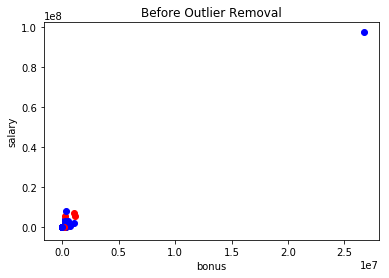

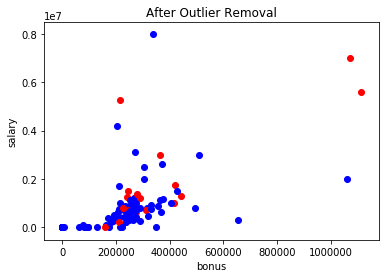

In [2]:
### Task 2: Remove outliers
### Scatterplot function that marks the person of interest in red.
def plotScatter(dat, title, labels=features_list):
    for point in dat:
        poi = point[0]
        if poi == 0:
            plt.scatter(point[1], point[2], color = "blue")
        else:
            plt.scatter(point[1], point[2], color = "red")
    plt.ylabel(labels[1])
    plt.xlabel(labels[2])
    plt.title(title)
    plt.show()
    
plotScatter(data, "Before Outlier Removal")
data_dict.pop("THE TRAVEL AGENCY IN THE PARK", 0)
data_dict.pop("TOTAL", 0)
data = featureFormat(my_dataset, features_list, sort_keys=True, remove_all_zeroes=False)
plotScatter(data, "After Outlier Removal")

## 2.1. Create New Features
I suspect that POIs would be the ones who are either getting the most salaries or bonuses. But simply adding these two features would give us inconsistent results since they vary in scales. Therefore, for my first feature, I add the scaled versions of the salary and bonus and call it *bonus_salary*.

I also assumed that POIs have a small circle and they would have constant communication with each other. AS a result, for my Second Feature, I divide the total emails sent to a POI over the total sent emails and call it *emailto_poi*.

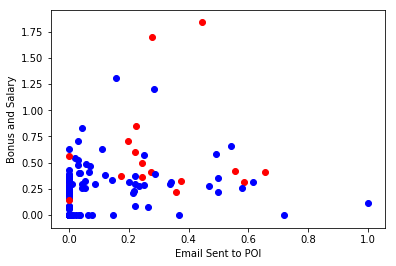

In [3]:
### Task 3: Create new feature(s)
from sklearn.preprocessing import MinMaxScaler

labels, features = targetFeatureSplit(data)

def doScale(dat):
    scaler = MinMaxScaler()
    rescaled = scaler.fit_transform(dat)
    return rescaled

def addNewFeature(dat, num, name):
    new = {}   
    keys = []
    if name not in features_list:
        features_list.append(name)

    for key in dat.keys():
        keys.append(key)
    keys = sorted(keys)
    for i, f in enumerate(keys):
        elem = {}
        elem[name] = num[i][0]
        for key, val in dat[f].items():
            elem[key] = val
        new[f] = elem
    return new

def selectFeatures(dat, var):
    new = []
    feat = []
    for i, u in enumerate(var):
        feat.append(features_list.index(u) - 1)
        
    for v in dat:
        elem = []
        for f in feat:
            elem.append(v[f])
        new.append(elem)
    return np.array(new)

def compute(dat, how):
    new = []
    if how == "sum":
        for i in dat:
            elem = []
            total = sum(i)
            elem.append(total)            
            new.append(elem)
    elif how == "divide":
        for i in dat:
            elem = []
            if (i[0] <= 0) | (i[1] <= 0):
                elem.append(0.)
            else:
                elem.append(i[0] / i[1])
            new.append(elem)
    return np.array(new)

def plotComparison(labels, feat1, feat2):
    for xx, jj, ii in zip(labels, feat1, feat2):
        if xx == 0:
            plt.scatter(jj, ii, color="b")
        else:
            plt.scatter(jj, ii, color="r")
        
    plt.ylabel("Bonus and Salary")
    plt.xlabel("Email Sent to POI")
    plt.show()

feat_re = doScale(features)
bonus_re = selectFeatures(feat_re, ["bonus", "salary"])
bonus_sm = compute(bonus_re, "sum")

email_from = selectFeatures(features, ["from_this_person_to_poi", "from_messages"])
emailto_poi = compute(email_from, "divide")

plotComparison(labels, emailto_poi, bonus_sm)

my_dataset = addNewFeature(my_dataset, bonus_sm, "bonus_salary")
my_dataset = addNewFeature(my_dataset, emailto_poi, "emailto_poi")

## 2.2. Test Custom Features
After creating my new features, I put them to the test. Below are the results:

- SVM:  0.8864
- Decision Tree:  0.8636
- Gaussian:  0.8409

SVM is a stronger classifier than the rest, granted that I have not configured the parameters. This is a good first step in exploring my data. I add *bonus_salary* and *emailto_poi* to my_dataset.

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC

data = featureFormat(my_dataset, features_list, sort_keys=True, remove_all_zeroes=False)
labels, features = targetFeatureSplit(data)

custom_features = selectFeatures(features, ["bonus_salary", "emailto_poi"])

features_train, features_test, labels_train, labels_test = \
    train_test_split(custom_features, labels, test_size=0.3, random_state=42)

clf = SVC()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print "SVM: ", round(accuracy_score(labels_test, pred), 4)

clf = DTC()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print "Decision Tree: ", round(accuracy_score(labels_test, pred), 4)

clf = GNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print "Gaussian: ", round(accuracy_score(labels_test, pred), 4)

SVM:  0.8864
Decision Tree:  0.8636
Gaussian:  0.8409


## 2.3. Automated Feature Selection
I want to make sure that I have covered everything, therefore, after adding my new features to *my_dataset*, I use SelectKBest to choose the best features that would give me the most information. Then, I print out each feature ranked according to their scores. Reviewing the results, it seems that my features are within the the top 6 of the best features.

In [5]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest

data = featureFormat(my_dataset, features_list,
                     sort_keys=True, remove_all_zeroes=False)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

clf = SelectKBest(k = 6)
clf.fit_transform(features_train, labels_train)
features_train_tr = clf.transform(features_train)
features_train_ts = clf.transform(features_test)

def findScores(score, names):
    new = {}
    board = []
    player = []
    for i, value in enumerate(score):
        player.append(names[i+1])
        board.append(round(value, 2))
    new["feature"] = player
    new["score"] = board
    return pd.DataFrame(new).sort_values(by=["score"], 
                                     ascending=False).set_index('feature', drop=True)

feature_sc = findScores(clf.scores_, features_list)
print feature_sc

                           score
feature                         
bonus                      34.21
bonus_salary               27.96
salary                     17.77
exercised_stock_options    16.93
total_stock_value          16.87
deferred_income            16.37
shared_receipt_with_poi    12.89
long_term_incentive        11.22
restricted_stock            9.79
total_payments              8.84
emailto_poi                 8.47
loan_advances               7.04
from_poi_to_this_person     6.18
to_messages                 5.49
expenses                    5.38
other                       3.36
director_fees               1.82
restricted_stock_deferred   0.70
from_messages               0.41
deferral_payments           0.05
from_this_person_to_poi     0.03


## 3.1. Try a Variety of Classifiers and Pick the Best
After trying several Classifiers, I ended up choosing *scalepcasvc* as my classifier because it had the highest accuracy score amongst the other classifiers that I have used. Below are the results of each classifier that I have used and the sequence of model.

- 0.89 : SelectKBest, RandomForest
- 0.89 : Scale, PCA, SVC
- 0.86 : SelectKBest, GaussianNB
- 0.89 : Scale, PCA, DecisionTree

In [6]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC

def doPipes(steps):
    pipe = Pipeline(steps)
    pipe.fit(features_train, labels_train).predict(features_test)
    return pipe

def getAccuracy(pipe):
    pred = pipe.fit(features_train, labels_train).predict(features_test)
    return round(accuracy_score(labels_test, pred), 2)

scalepcasvc = doPipes([
    ("scale", MinMaxScaler()),
    ("pca", PCA()),
    ("svc", SVC())
])

selectKrfc = doPipes([
    ("selectK", SelectKBest()),
    ("rfc", RFC())
])

selectKsteps = doPipes([
    ("selectK", SelectKBest()),
    ("gnb", GNB())
])

scalepcadtc = doPipes([
    ("scale", MinMaxScaler()),
    ("pca", PCA()),
    ("dtc", DTC())
])

print getAccuracy(selectKrfc), ": SelectKBest, RandomForest"
print getAccuracy(scalepcasvc), ": Scale, PCA, SVC"
print getAccuracy(selectKsteps), ": SelectKBest, GaussianNB"
print getAccuracy(scalepcasvc), ": Scale, PCA, DecisionTree"

0.89 : SelectKBest, RandomForest
0.89 : Scale, PCA, SVC
0.86 : SelectKBest, GaussianNB
0.89 : Scale, PCA, DecisionTree


## 4.1. Tune Best Algorithm
After selecting my classifier, I then tune the parameters in an attempt to find the appropriate configuration that would give me the best results. If I do not do this well or if I do not do it at all, I will run the risk of missing out on the best configuration of my chosen classifier. To help me tune my parameters, I will be using *GridSearchCV* to help me run several versions of the parameters and find the best one. I include a range of n_components configuration for my PCA ranging from 1 to 6 components. I then try linear and rbf kernels from my SVC and a range sequence of C parameters from 1 to 100.

In [7]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

from sklearn.grid_search import GridSearchCV as GridSVC
from sklearn.metrics import classification_report as classReport

paramsvc = dict(
    pca__n_components = [1, 2, 3, 4, 5, 6],
    svc__kernel = ["linear", "rbf"],
    svc__C = [1, 10, 20, 50, 100] )

clf = GridSVC(scalepcasvc, param_grid=paramsvc)

C:\Users\Chris\Anaconda3\envs\py27\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 5.1. Validation
Validation is an important part of the machine learning process because it allows us to check our algoritm's effectiveness. The aim of machine learning is to effectively classify certain datapoints based on their features with the highest precision and accuracy. But not too high that we run into overfitting. Through validation, we are able to determine if we are overfitting or if we are not getting an efficient algorithm.

## 6.1. Evaluation Metrics
Running getClassReport, I get an accuracy score of 0.89, which is the same score had I not tuned the parameters. This is to be expected because we are working with a small dataset that does not have that much datapoints.

After running the *getClassReport*, I get an average precision score of 0.79, which means that my classifier is able to correctly predict 79% of people as a POI based on their features. I also got a recall score of 0.89, which means that my classifier is able to identify 0.89 of the pople as a POI correctly based on their features.

    Accuracy Score: 0.89
    
    Validation Score
    labels    precis    recall    F1       support
    0.0       0.89      1.00      0.94     39
    1.0       0.00      0.00      0.00      5
              0.79      0.89      0.83     44      avg / total

In [8]:
def getClassReport(pipe):
    pipe.fit(features_train, labels_train)
    pred = pipe.predict(features_test)
    return classReport(labels_test, pred)

print getAccuracy(clf), ": clf Score"
print getClassReport(clf)

0.89 : clf Score
             precision    recall  f1-score   support

        0.0       0.89      1.00      0.94        39
        1.0       0.00      0.00      0.00         5

avg / total       0.79      0.89      0.83        44



C:\Users\Chris\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)